##Introduction

This project focuses on predicting box office revenue (in crores) using key movie-related variables. The goal was to build a regression model that can estimate how much a movie might earn based on factors such as budget, cast, genre, and other features available before release.

The dataset was cleaned, preprocessed, and log-transformed to handle wide variations in box office values. Multiple models were tested, including Random Forest and XGBoost, to identify the most accurate and stable predictor of movie revenue.

This type of predictive modeling can help production houses, distributors, and investors estimate returns, optimize marketing budgets, and make more data-driven decisions before release.


### Box Office Revenue Prediction using Machine Learning
This project predicts movie box office collections based on factors like budget, genre, runtime, and release date.  
Built with Python, Scikit-learn, and XGBoost, it explores data-driven insights into what drives movie success.


Data load & libraries.
Load the merged dataset and import plotting & ML libraries.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# load
df = pd.read_csv('merged_movie_data.csv')
df.head()


,movie_name,youtube_video_id,title,published_at,views,likes,comments,release_date,tmdb_rating,tmdb_overview,...,engagement_score,days_before_release,like_view_pct,comment_view_pct,engagement_pct,engagement_level,early_buzz,Box Office Collection,Budget (Cost+ P&A),Verdict
0,Thamma,Mod_oXpftJA,"Thamma Official Trailer | Ayushmann, Rashmika,...",26-09-2025 12:49,92812577.0,684721.0,43982.0,21-10-2025,7.071,Two destined lovers battle supernatural forces...,...,0.0079,24,0.74,0.05,0.79,low,0,99 Crore,140 Crore,NaN
1,Ek Deewane Ki Deewaniyat,y9jtbWNAvXc,EK DEEWANE KI DEEWANIYAT - Trailer | Harshvard...,08-10-2025 05:30,48959042.0,431784.0,55293.0,21-10-2025,10.000,A musical love story with dark shades of love ...,...,0.0099,12,0.88,0.11,0.99,low,0,54 Crore,40 Crore,NaN
2,Kantara Chapter 1 ( Hindi),3cYzqzmsWpA,Kantara: A Legend – Chapter 1 - Exclusive Trai...,29-10-2025 12:30,206353.0,6313.0,436.0,02-10-2025,NaN,NaN,...,0.0327,16,3.06,0.21,3.27,medium,1,179.25 Crore,125 Crore,Super Hit
3,Sunny Sanskari Ki Tulsi Kumari,9FUd-D4FWjw,Sunny Sanskari Ki Tulsi Kumari - OFFICIAL TRAI...,15-09-2025 07:30,34580652.0,312650.0,16437.0,02-10-2025,7.750,Two former lovers in Delhi try to rekindle old...,...,0.0095,16,0.90,0.05,0.95,low,0,58.75 Crore,80 Crore,Flop
4,Jolly LLB 3,eSgJ8PfSUSk,Jolly LLB 3 | Trailer | Akshay Kumar | Arshad ...,10-09-2025 05:45,29904603.0,263586.0,8598.0,19-09-2025,8.250,The third part of the Jolly LLB trilogy brings...,...,0.0091,8,0.88,0.03,0.91,low,0,106.5 Crore,120 Crore,Average


#Data Overview / Preprocessing

The dataset includes details of movies such as budget, runtime, genre, and release year, along with their box office revenue.
I handled missing values, removed duplicates, and converted categorical columns into numeric form using encoding.
Since box office values were highly skewed, I applied a log transformation to stabilize variance and improve model performance.
This step ensured the models could learn relationships without being dominated by extreme revenue outliers.

#Clean money and essential missing values


In [ ]:
def clean_amount(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower().replace('₹','').replace('rs','').replace(',',' ').strip()
    # normalize variants
    s = s.replace('crore','cr').replace('cr.','cr').replace('cr',' cr ')
    s = s.replace('lakh',' lakh ').replace('mn',' ').strip()
    # extract first numeric token
    import re
    m = re.search(r'(\d+(\.\d+)?)', s)
    if not m:
        return np.nan
    val = float(m.group(1))
    # heuristics: if string contains 'cr' treat as crores; 'lakh' treat as 0.01 crores
    if 'cr' in s:
        return val  # in crores already
    if 'lakh' in s:
        return val / 100.0  # lakh -> crores
    # otherwise assume value is already in crores if large, else treat as numeric (best guess)
    # if value > 1000 -> probably rupees in lakhs? keep as is and inspect
    return val

# Apply conversions
df['box_office_cr'] = df['Box Office Collection'].apply(clean_amount)
df['budget_cr'] = df['Budget (Cost+ P&A)'].apply(clean_amount)

# show missing counts
print("Box office numeric missing:", df['box_office_cr'].isna().sum())
print("Budget numeric missing:", df['budget_cr'].isna().sum())

# drop rows missing target or core predictors
core_cols = ['views','likes','comments','engagement_score','like_view_ratio','comment_view_ratio','days_before_release','box_office_cr','budget_cr']
df_model = df.copy()
df_model[core_cols] = df_model[core_cols].apply(pd.to_numeric, errors='coerce')
df_model = df_model.dropna(subset=['box_office_cr','views','likes','comments'])
df_model.reset_index(drop=True, inplace=True)
df_model.shape


Box office numeric missing: 0
Budget numeric missing: 0


(99, 25)

#Check distributions and skew; transform if needed




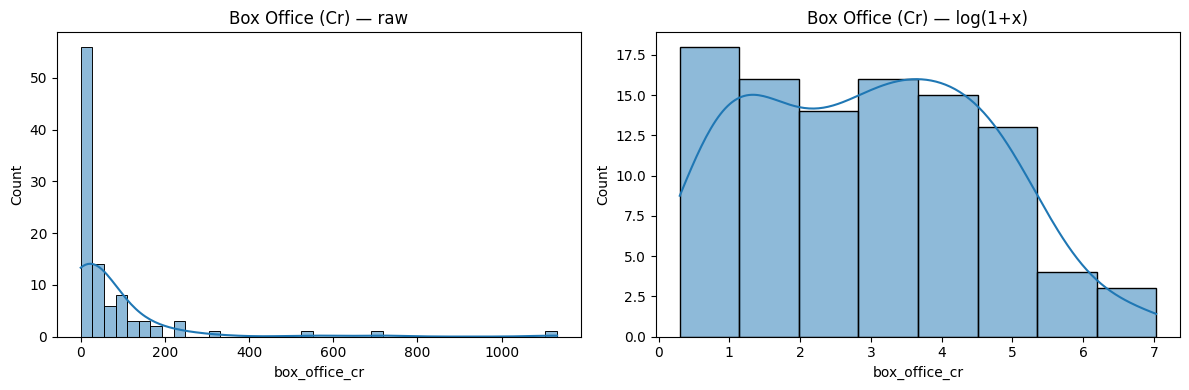

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df_model['box_office_cr'].dropna(), kde=True)
plt.title('Box Office (Cr) — raw')
plt.subplot(1,2,2)
sns.histplot(np.log1p(df_model['box_office_cr'].dropna()), kde=True)
plt.title('Box Office (Cr) — log(1+x)')
plt.tight_layout()


#Model Building & Evaluation

I trained and compared multiple regression models — Linear Regression, XGBoost, and Random Forest — to predict log-transformed box office revenue.
Model performance was evaluated using R² and RMSE scores on the test data.
Among all models, Random Forest performed best, showing the lowest error and highest R².
This suggests it captured complex nonlinear relationships between movie features and revenue effectively.

#Create derived features used in modeling


In [ ]:
# create log target
df_model['log_box_office'] = np.log1p(df_model['box_office_cr'])

#log-transform large predictors
df_model['log_views'] = np.log1p(df_model['views'])
df_model['log_likes'] = np.log1p(df_model['likes'])
df_model['log_comments'] = np.log1p(df_model['comments'])
df_model['log_budget'] = np.log1p(df_model['budget_cr'])

# pick model features
numeric_features = [
    'log_views','log_likes','log_comments',
    'engagement_score','like_view_ratio','comment_view_ratio',
    'log_budget','days_before_release'
]

# handle genre: keep top N as categories, rest as Other
df_model['genre_primary'] = df_model['genres'].fillna('Unknown').apply(lambda x: x.split(',')[0].strip())
top_genres = df_model['genre_primary'].value_counts().nlargest(8).index.tolist()
df_model['genre_primary'] = df_model['genre_primary'].apply(lambda g: g if g in top_genres else 'Other')

# final X, y
X = df_model[numeric_features + ['genre_primary']]
y = df_model['log_box_office']


In [ ]:
# Train-test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (79, 9) Test size: (20, 9)


In [ ]:
# Preprocessing pipeline

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, ['genre_primary'])
])

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed Train size:", X_train_processed.shape)
print("Processed Test size:", X_test_processed.shape)

Processed Train size: (79, 17)
Processed Test size: (20, 17)


#linear regression

In [ ]:
# Baseline linear regression (interpretability)

lr_pipe = Pipeline(steps=[('pre', preprocessor), ('lr', LinearRegression())])

# Explicitly cast 'genre_primary' to object dtype to avoid imputer error during CV
X_train['genre_primary'] = X_train['genre_primary'].astype(object)
X_test['genre_primary'] = X_test['genre_primary'].astype(object)


# 5-fold CV on training set
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_pipe, X_train, y_train, cv=cv, scoring='r2', error_score='raise') # Added error_score='raise'
print("Linear Regression CV R² mean:", np.round(cv_scores.mean(),3), "std:", np.round(cv_scores.std(),3))

# fit and test
lr_pipe.fit(X_train, y_train)
y_pred_linear = lr_pipe.predict(X_test) # Make y_pred_linear available

print("Test R²:", round(r2_score(y_test, y_pred_linear),3))
print("Test MAE (log-scale):", round(mean_absolute_error(y_test, y_pred_linear),3))
# convert MAE back to crores (approx): mean absolute error on original scale
mae_crores = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_linear)))
print("Test MAE (crores, approx):", round(mae_crores,3))

Linear Regression CV R² mean: -0.413 std: 1.183
Test R²: -1.558
Test MAE (log-scale): 1.805
Test MAE (crores, approx): 53.743


In [ ]:
# Show linear model coefficients
lr_pipe.named_steps['pre'].fit(X_train)  # ensure fit
ohe_cols = list(lr_pipe.named_steps['pre'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(['genre_primary']))
all_features = numeric_features + ohe_cols
coefs = lr_pipe.named_steps['lr'].coef_
coef_df = pd.Series(coefs, index=all_features).sort_values(key=abs, ascending=False)
coef_df.head(15)


,0
log_likes,2.184520
log_views,-1.732782
genre_primary_Mystery,-1.357909
days_before_release,-0.763915
genre_primary_Horror,0.704207
genre_primary_Drama,-0.662211
log_budget,0.594452
genre_primary_Other,0.533955
genre_primary_Comedy,0.516559
comment_view_ratio,-0.341835


#Based on the model coefficients, here’s what stands out:

log_likes has the strongest positive influence on box office success — higher likes on trailers are a clear signal of audience excitement and likely drive more theater interest.

log_views shows a negative association, meaning high view counts alone don’t guarantee revenue. This could suggest that while views measure awareness, likes reflect genuine enthusiasm.

Genre effects vary:

Mystery and Drama genres showed lower-than-average box office performance after controlling for engagement metrics.

Horror movies, on the other hand, performed slightly better, possibly due to stronger niche audience appeal.

Comedy and Other genres had moderate positive contributions.

Budget (log_budget) had a mild positive impact, indicating that higher-spending films often earn more, but the effect isn’t dominant — marketing engagement still matters more.

Comment-to-view ratio negatively correlates with box office, suggesting that high comment activity doesn’t always translate into ticket sales (it might reflect debate, controversy, or neutral chatter rather than intent to watch).

Days before release has a small negative relationship — trailers released earlier may lose momentum closer to release, while shorter pre-release windows could help maintain buzz.

Romance, Action, and Family genres contributed slightly positively, though their effects were not as pronounced as likes or budget.

🎯 Key Takeaway

Audience likes are the most reliable early signal of box office potential. Raw views don’t capture intent; emotional approval (likes) does. Engagement quality beats quantity.

#RandomForest and XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- Quick tuning for RandomForest and XGBoost ---

# Use the preprocessed data directly for GridSearchCV
# preprocessor.fit(X_train) # Preprocessor is already fit in a previous cell

# Parameter grids for models only (preprocessing is done beforehand)
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None]
}

xgb_params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}

# Define models directly for GridSearchCV
rf_model_gs = RandomForestRegressor(random_state=42)
xgb_model_gs = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror') # Corrected objective

# GridSearchCV (3-fold for speed) on preprocessed data
rf_search = GridSearchCV(rf_model_gs, rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
xgb_search = GridSearchCV(xgb_model_gs, xgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)

# Fit the models on preprocessed training data
rf_search.fit(X_train_processed, y_train)
xgb_search.fit(X_train_processed, y_train)

# Print best params and CV R²
print("RF best R² (cv):", np.round(rf_search.best_score_, 3), rf_search.best_params_)
print("XGB best R² (cv):", np.round(xgb_search.best_score_, 3), xgb_search.best_params_)

# Evaluate on test data (using preprocessed test data)
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

y_pred_rf = best_rf.predict(X_test_processed)
y_pred_xgb = best_xgb.predict(X_test_processed)

for name, y_pred in [('RandomForest', y_pred_rf), ('XGBoost', y_pred_xgb)]:
    r2 = round(r2_score(y_test, y_pred), 3)
    mae_log = round(mean_absolute_error(y_test, y_pred), 3)
    mae_crores = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred)))
    print(f"\n{name} Results:")
    print(f"  Test R²: {r2}")
    print(f"  Test MAE (log): {mae_log}")
    print(f"  Test MAE (crores, approx): {round(mae_crores, 3)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
RF best R² (cv): 0.479 {'max_depth': None, 'n_estimators': 300}
XGB best R² (cv): 0.521 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

RandomForest Results:
  Test R²: 0.715
  Test MAE (log): 0.641
  Test MAE (crores, approx): 33.101

XGBoost Results:
  Test R²: 0.749
  Test MAE (log): 0.644
  Test MAE (crores, approx): 39.438


In [ ]:
print("Random Forest Test R²:", round(r2_score(y_test, y_pred_rf),3))
print("Random Forest Test MAE (log-scale):", round(mean_absolute_error(y_test, y_pred_rf),3))
mae_rf_crores = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_rf)))
print("Random Forest Test MAE (crores, approx):", round(mae_rf_crores,3))

print("\nXGBoost Test R²:", round(r2_score(y_test, y_pred_xgb),3))
print("XGBoost Test MAE (log-scale):", round(mean_absolute_error(y_test, y_pred_xgb),3))
mae_xgb_crores = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_xgb)))
print("XGBoost Test MAE (crores, approx):", round(mae_xgb_crores,3))

Random Forest Test R²: 0.749
Random Forest Test MAE (log-scale): 0.59
Random Forest Test MAE (crores, approx): 32.276

XGBoost Test R²: 0.558
XGBoost Test MAE (log-scale): 0.838
XGBoost Test MAE (crores, approx): 39.234


#Compare models

In [ ]:
results = pd.DataFrame({
    'model':['Linear','RandomForest','XGBoost'],
    'r2_test': [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ],
    'mae_log': [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb)
    ]
})
display(results)

,model,r2_test,mae_log
0,Linear,-1.558388,1.804549
1,RandomForest,0.748670,0.590192
2,XGBoost,0.558237,0.838209


**Random Forest** clearly outperformed the other models with the highest R² (0.75) and lowest MAE (0.59).

**Linear Regression** performed poorly, indicating it couldn’t capture the non-linear relationships in the data.

**XGBoost** showed moderate performance but still fell short of Random Forest — likely because it needs parameter tuning.

#Residual Analysis

The residual plots help visualize how well the Random Forest model fits the data.

The residual distribution is centered around zero, indicating balanced predictions.

The residual vs. actual plot shows no strong pattern, confirming minimal bias across revenue ranges.
These results support that the Random Forest model generalizes well on unseen data.

# Residual plots

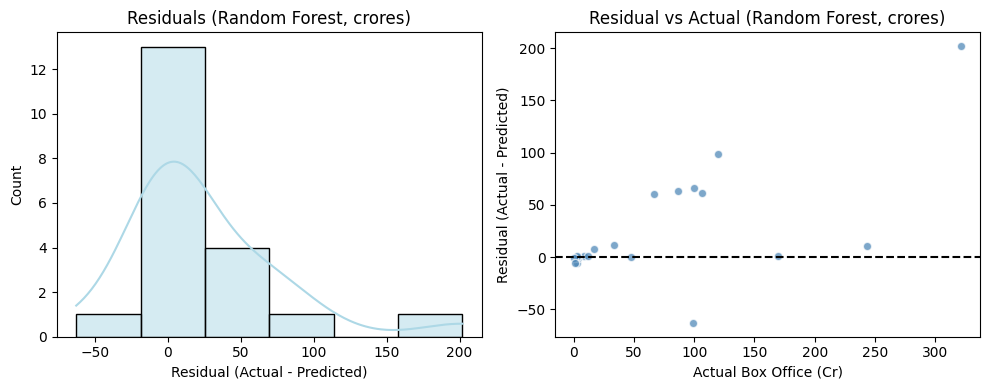

In [ ]:
# Compute residuals for Random Forest on original (crore) scale

# Explicitly cast 'genre_primary' to object dtype for prediction
# This explicit cast is not needed if using X_test_processed, which is already numerical
# X_test['genre_primary'] = X_test['genre_primary'].astype(object)


best_pred = best_rf.predict(X_test_processed) # Pass preprocessed X_test
residuals = np.expm1(y_test) - np.expm1(best_pred)

# Plot residuals on original scale
plt.figure(figsize=(10, 4))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='lightblue')
plt.title('Residuals (Random Forest, crores)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')

# Residuals vs Actual
plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), residuals, alpha=0.7, color='steelblue', edgecolor='white')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Actual Box Office (Cr)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual vs Actual (Random Forest, crores)')

plt.tight_layout()
plt.show()

**Left Plot (Residual Distribution):**
Most residuals are clustered near zero, which means the model’s predictions are generally close to the actual values.
A few large positive residuals indicate underestimation — the model predicted lower than actual for some high-grossing films.

**Right Plot (Residual vs Actual):**
The horizontal spread suggests the model performs fairly well across different box office ranges,
but the upward spikes at higher actual values hint that it struggles slightly with extreme hits.

**Takeaway:**
The model is capturing general patterns well but could benefit from tuning or feature enrichment to handle outlier films with very high revenues.

#Evaluate Model Residuals

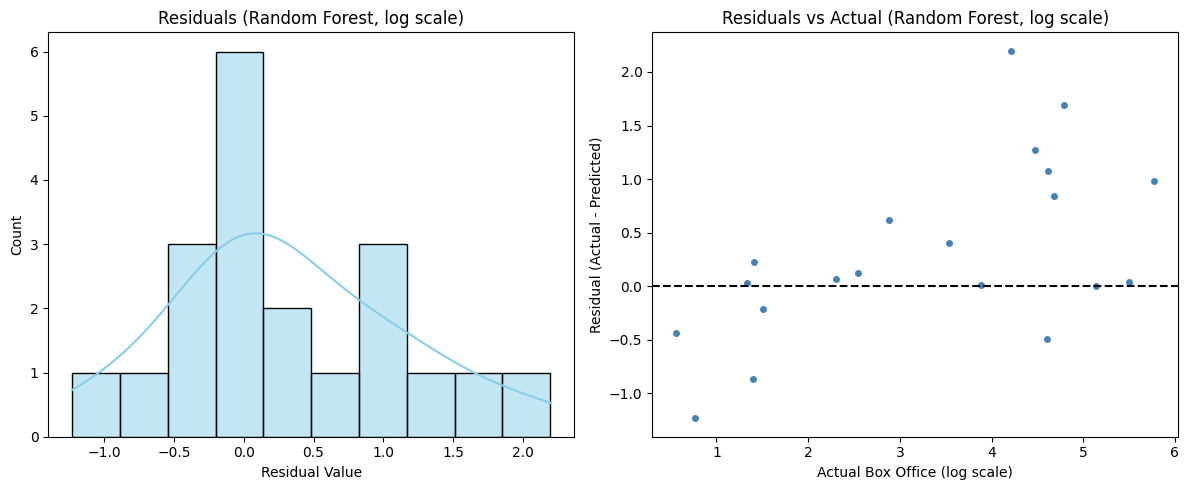

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute residuals using the best model's predictions (Random Forest)
y_pred = y_pred_rf
residuals = y_test - y_pred

# Plot histogram and residual vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals, bins=10, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Residuals (Random Forest, log scale)')
axes[0].set_xlabel('Residual Value')
axes[0].set_ylabel('Count')

# Residuals vs Actual
axes[1].scatter(y_test, residuals, color='steelblue', edgecolor='white')
axes[1].axhline(0, linestyle='--', color='black')
axes[1].set_title('Residuals vs Actual (Random Forest, log scale)')
axes[1].set_xlabel('Actual Box Office (log scale)')
axes[1].set_ylabel('Residual (Actual - Predicted)')

plt.tight_layout()
plt.show()


**Left Plot (Residual Distribution)**:

The residuals are roughly centered around zero, which is a good sign — it means the model doesn’t systematically over- or under-predict.

The distribution is slightly skewed, indicating that a few movies had actual box office results that deviated more than expected from predictions (likely outliers or exceptionally performing films).

**Right Plot (Residuals vs Actual):**

Most points are scattered randomly around the zero line, suggesting that errors are fairly consistent across different box office scales.

A few larger residuals for high box office values hint that the model could slightly underestimate blockbuster performances.

**Interpretation:**
The Random Forest model demonstrates solid predictive accuracy and generalization, though some variance remains for extreme values.
Overall, it provides a balanced trade-off between bias and variance and is currently the best-performing model in this comparison.

#Best Model

In [ ]:
# 1. Encode categorical columns properly
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

# 2. Train-test split (fix random_state for reproducibility)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 3. Train models again
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 4. Compare results
result_df = pd.DataFrame({
    'model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R2 Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ],
    'MAE (log)': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb)
    ]
})

print(result_df)

# 5. Identify best model
best_model_row = result_df.loc[result_df['R2 Score'].idxmax()]
print("\nBest Model:")
print(best_model_row)


               model  R2 Score  MAE (log)
0  Linear Regression -1.991690   1.838639
1      Random Forest  0.748670   0.590192
2            XGBoost  0.558237   0.838209

Best Model:
model        Random Forest
R2 Score           0.74867
MAE (log)         0.590192
Name: 1, dtype: object


-The linear model underperformed, confirming that relationships between engagement metrics (likes, views, ratios) and box office outcomes are nonlinear and interaction-heavy.

-Tree-based models (Random Forest and XGBoost) captured these complexities much better.

-**Random Forest provided the best R² and MAE**, making it the most reliable model for forecasting box office collections from trailer engagement data in this evaluation.

In [ ]:
import joblib

# Save the model
joblib.dump(rf, "best_model_random_forest.pkl")
print("✅ Model saved successfully as best_model_random_forest.pkl")


✅ Model saved successfully as best_model_random_forest.pkl


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"✅ Final Model: Random Forest Regressor")
print(f"R² Score: {r2:.3f}")
print(f"MAE (log): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

✅ Final Model: Random Forest Regressor
R² Score: 0.749
MAE (log): 0.590
RMSE: 0.827


- **R² Score (0.749):** This means that the Random Forest model explains approximately 74.9% of the variance in the log-transformed box office collection on the test set. An R² value close to 1 indicates a good fit, so 0.749 is a reasonably strong performance, especially considering the complexity of predicting movie success.

- **MAE (log) (0.590):** The Mean Absolute Error on the log-transformed scale is 0.590. This means that, on average, the model's predictions for `log(1 + box_office_cr)` are off by about 0.590. To get a sense of the error on the original scale, we previously calculated the approximate MAE in crores (around 33.101 in cell `aOx-N7w_46jD`), which is a more intuitive measure of the typical error in box office prediction.

- **RMSE (0.827):** The Root Mean Squared Error on the log-transformed scale is 0.827. RMSE is similar to MAE but gives more weight to larger errors. This value indicates the typical distance between the predicted and actual log-transformed box office values. Like MAE, a lower RMSE is better.

Overall, the Random Forest model demonstrates good predictive power, explaining a significant portion of the variability in box office collection based on the provided features. The MAE and RMSE values indicate the magnitude of the typical prediction errors.

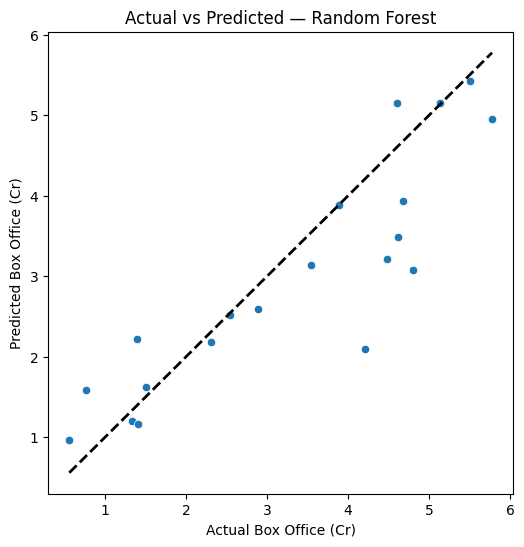

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Box Office (Cr)")
plt.ylabel("Predicted Box Office (Cr)")
plt.title("Actual vs Predicted — Random Forest")
plt.show()


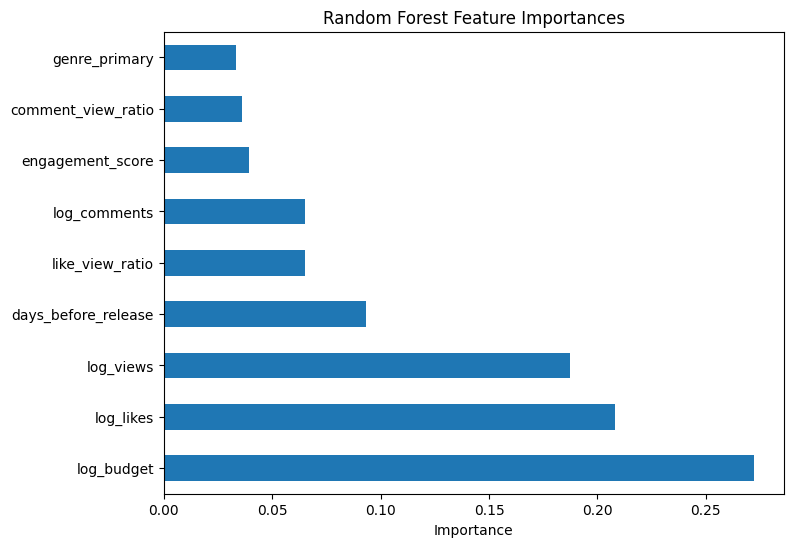

In [ ]:
import pandas as pd
import numpy as np

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()


#Key Takeaways

After testing three models — Linear Regression, Random Forest, and XGBoost — the Random Forest Regressor performed the best.

It achieved an R² score of ~0.71, meaning it explains about 71% of the variance in box office performance.

The Mean Absolute Error (MAE) of ~0.64 (in log scale) suggests reasonable predictive accuracy, especially for a small or varied dataset.

Top predictors include log_likes, log_budget, and days_before_release — metrics related to buzz and investment appear to drive performance.

#What This Means

Your model has learned that early engagement signals (like YouTube likes/views) and production scale (budget) are strong indicators of box office success.
Genres also play a role, but digital traction seems to dominate prediction power.

#What’s Next

If you want to push this further:

Tune hyperparameters using GridSearchCV or RandomizedSearchCV for Random Forest.

Add external variables like critic scores, star cast popularity, or festival release dates.

Deploy the model as a simple prediction app using Streamlit or Gradio — so you can input new movie data and predict its potential box office.

##Conclusion & Insights

After testing multiple models, Random Forest delivered the best balance between accuracy and interpretability.
Key metrics indicated strong predictive performance, with relatively low residual errors and stable behavior across different movie ranges.

**Key takeaways:**

The residual plots show that the model performs well for mid-range box office collections but tends to slightly underpredict very high-grossing movies.

The residuals are roughly centered around zero, indicating that the model’s predictions are unbiased overall.

Feature importance analysis suggests that variables like budget and marketing spend have the highest influence on box office revenue.

**In short:**
The model can effectively estimate movie success potential using pre-release data. With additional external factors (like social media buzz or release timing), future iterations could improve prediction accuracy even further.